# Denoising Model Training

In [1]:
%load_ext autoreload
%autoreload 2

!python --version

Python 3.13.11


## Data Load and presentation

In [2]:
import gc
gc.collect()

52

In [3]:
PATCH_SIZE_2D = (64, 64)
PATCH_SIZE_3D = (32, 64, 64)
PATCH_SIZE = PATCH_SIZE_2D

In [ ]:
import pathlib
import sys, os
import tifffile
from torch.utils.data import DataLoader
from dataset import CalciumDataset

if "google.colab" in sys.modules:
    train_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/train")
    valid_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid")
    ground_truth_path = pathlib.Path("/content/drive/MyDrive/public/ai4life-cidc2025/valid/F0.tif")
else:
    train_path = pathlib.Path("data/train")
    valid_path = pathlib.Path("data/valid")
    ground_truth_path = pathlib.Path("data/valid/F0.tif")

train_paths = list(train_path.glob("*.tif"))
valid_paths = [p for p in valid_path.glob("*.tif") if "f0" not in p.name.lower()]
ground_truth = tifffile.imread(ground_truth_path)

print(len(train_paths), len(valid_paths))

train_dataset = CalciumDataset(train_paths, patch_size=PATCH_SIZE, samples_per_epoch=8000)
valid_dataset = CalciumDataset(valid_paths, patch_size=PATCH_SIZE, samples_per_epoch=2000)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)

4 3


In [5]:
for data in train_dataset.normals:
    print(data)
    # print(data.shape, data.max(), data.min())

(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)
(-100.0, 1500.0)


## Model architecture


In [ ]:
from models.unet import UNet

## Model training

In [ ]:
from training import train

best_model = None
model = UNet()
best_model = train(model, train_loader, valid_loader)

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import numpy as np

# def train_one_epoch(model, data_loader, loss_fn, optimizer, device):
#     model.train()

#     loop = tqdm(data_loader, leave=True)
#     losses = []
#     for batch_idx, (masked, mask, target) in enumerate(loop):
#         masked = masked.to(device)
#         mask = mask.to(device)
#         target = target.to(device)

#         output = model(masked)
#         loss = loss_fn(output[mask], target[mask])
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         loop.set_postfix(loss=loss.item())

#     loop.set_postfix(loss=np.mean(losses))
#     return np.mean(losses)

# def evaluate(model, data_loader, loss_fn, device):
#     model.eval()

#     loop = tqdm(data_loader, leave=True)
#     losses = []
#     for batch_idx, (masked, mask, target) in enumerate(loop):
#         masked = masked.to(device)
#         mask = mask.to(device)
#         target = target.to(device)

#         with torch.no_grad():
#             output = model(masked)
#             loss = loss_fn(output[mask], target[mask])
#             losses.append(loss.item())

#         loop.set_postfix(loss=loss.item())

#     loop.set_postfix(loss=np.mean(losses))
#     return np.mean(losses)

# model = UNet(in_channels=1, out_channels=1)
# optimizer = optim.Adam(model.parameters())
# loss_fn = nn.MSELoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# best_loss = float("inf")
# best_model = None

# for epoch in range(20):
#     train_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
#     valid_loss = evaluate(model, valid_loader, loss_fn, device)
#     print(f"Epoch: {epoch}, Valid Loss: {valid_loss}")
#     if valid_loss < best_loss:
#         best_loss = valid_loss
#         best_model = model.state_dict()
#         torch.save(best_model, "models/best_model.pth")

# Full Images Evaluation

## Denoising validation dataset

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def denoise_frame(model, frame, device, patch_size, slide_window=16, batch_size=16):
    model.eval()
    if len(patch_size) != 2:
        raise ValueError("Patch size must be a tuple of length 2")

    frame = frame.unsqueeze(0).unsqueeze(0).float()

    padding_frame = F.pad(frame, (slide_window, slide_window, slide_window, slide_window), mode='reflect')
    padding_frame = padding_frame.to(device)

    output_sum = torch.zeros_like(padding_frame)
    count_map = torch.zeros_like(padding_frame)

    batch_patches = []
    batch_coords = []

    _, _, h_pad, w_pad = padding_frame.shape

    with torch.no_grad():
        denoised_frame = torch.zeros_like(padding_frame)
        for h in range(0, padding_frame.shape[2] - patch_size[0] + 1, slide_window):
            for w in range(0, padding_frame.shape[3] - patch_size[1] + 1, slide_window):
                patch = padding_frame[:, :, h:h+patch_size[0], w:w+patch_size[1]]
                batch_patches.append(patch)
                batch_coords.append((h, w))

                if len(batch_patches) == batch_size:
                    batch_patches = torch.cat(batch_patches, dim=0)
                    denoised_batch = model(batch_patches)
                    for i, (ph, pw) in enumerate(batch_coords):
                        output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
                        count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1
                    batch_patches = []
                    batch_coords = []
                # denoised_patch = model(patch)
                # output_sum[:, :, h:h+patch_size[0], w:w+patch_size[1]] += denoised_patch
                # count_map[:, :, h:h+patch_size[0], w:w+patch_size[1]] += 1
                # denoised_frame[:,:,h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
        if len(batch_patches) > 0:
            batch_patches = torch.cat(batch_patches, dim=0)
            denoised_batch = model(batch_patches)
            for i, (ph, pw) in enumerate(batch_coords):
                output_sum[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += denoised_batch[i]
                count_map[:,:,ph:ph+patch_size[0], pw:pw+patch_size[1]] += 1

        count_map[count_map == 0] = 1.0
        denoised_frame = output_sum / count_map
        denoised_frame = denoised_frame[:, :, slide_window:-slide_window, slide_window:-slide_window]
    return denoised_frame

def denoise_multi_frame(model, frames, device, patch_size, slide_window=16, batch_size=16):
    model.eval()

    denoised_frames = torch.zeros_like(frames)
    loop = tqdm(range(frames.shape[0]), leave=True)
    for t in loop:
        frame = frames[t].to(device)
        denoised_frame = denoise_frame(model, frame, device, patch_size, slide_window, batch_size)
        denoised_frames[t] = denoised_frame
    # print(denoised_frame)
    return denoised_frames

def denoise_video(model, video, device, patch_size):
    model.eval()
    with torch.no_grad():
        denoised_video = torch.zeros_like(video)
        loop = tqdm(range(video.shape[0]), leave=True)
        for t in loop:
            frame = video[t].to(device)
            denoised_frame = torch.zeros_like(frame)
            for h in range(0, frame.shape[0] - patch_size[0], patch_size[0]):
                for w in range(0, frame.shape[1] - patch_size[1], patch_size[1]):
                    patch = frame[h:h+patch_size[0], w:w+patch_size[1]]
                    patch = patch.unsqueeze(0).unsqueeze(0).float().to(device)
                    denoised_patch = model(patch)
                    denoised_frame[h:h+patch_size[0], w:w+patch_size[1]] = denoised_patch
            denoised_video[t] = denoised_frame
    return denoised_video

# Instantiate the model again
model_eval = UNet(in_channels=1, out_channels=1)
# Load the best weights
if best_model is None:
    best_model = torch.load("models/best_model.pth")
model_eval.load_state_dict(best_model)
model_eval.to(device)
model_eval.eval()

denoised_videos = []
for video in valid_dataset.images:
    video = torch.from_numpy(video).to(device)
    print(video.shape)
    # denoised_video = denoise_video(model, video, device, (64, 64))
    denoised_video = denoise_multi_frame(model_eval, video, device, PATCH_SIZE, 32, 256)
    denoised_videos.append(denoised_video.squeeze(0).squeeze(0).cpu().numpy())

denoised_videos[0][0]

torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [00:25<00:00, 58.91it/s]


torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [00:25<00:00, 59.27it/s]


torch.Size([1500, 490, 490])


100%|██████████| 1500/1500 [00:25<00:00, 59.22it/s]


array([[267, 228, 249, ...,  86,  60,  52],
       [300, 286, 341, ..., 101,  88,  82],
       [273, 305, 271, ..., 119, 107,  80],
       ...,
       [131, 110, 172, ..., 262, 344, 299],
       [112, 109, 148, ..., 239, 289, 310],
       [129,  95, 145, ..., 251, 387, 314]], shape=(490, 490), dtype=int16)

## Evaluate SNR

In [ ]:
import numpy as np

def calc_snr(clean, noisy, eps=1e-8):
    signal = np.mean(clean ** 2)
    noise = np.mean((clean - noisy) ** 2)
    if signal == 0:
        return 0.0
    return 10 * np.log10(signal / (noise + eps))

def calc_metrics(clean_video, denoised_video, alpha=0.5, eps=1e-8):

    T, H, W = clean_video.shape

    # --- 1. 初始化容器 ---
    # sSNR: 我們只需要存每一幀算出的一個純量數值 (Scalar)
    s_snr_list = []

    # tSNR: 我們需要兩個 (H, W) 的累加器，用來存總和
    # 使用 float64 以避免累加過程溢位
    acc_pixel_signal_sq = np.zeros((H, W), dtype=np.float64)
    acc_pixel_noise_sq = np.zeros((H, W), dtype=np.float64)

    # --- 2. 逐幀迴圈 (Streaming Loop) ---
    for t in range(T):
        # 取出一幀 (這樣只佔用一張圖的 RAM)
        # 轉成 float64 確保運算精度
        frame_clean = clean_video[t].astype(np.float64)
        frame_restored = denoised_video[t].astype(np.float64)

        # 算出這一幀的誤差
        frame_noise = frame_clean - frame_restored

        # --- A. 處理 sSNR (Spatial) ---
        # 針對這單一幀算 SNR
        f_sig_pow = np.mean(frame_clean ** 2)
        f_ns_pow = np.mean(frame_noise ** 2)

        if f_sig_pow > eps:
            s_snr_val = 10 * np.log10(f_sig_pow / (f_ns_pow + eps))
        else:
            s_snr_val = 0.0 # 若該幀全黑

        s_snr_list.append(s_snr_val)

        # --- B. 處理 tSNR (Temporal) ---
        # 把這一幀的平方值「累加」到蓄水池裡
        acc_pixel_signal_sq += (frame_clean ** 2)
        acc_pixel_noise_sq += (frame_noise ** 2)

    # --- 3. 迴圈結束，計算最終結果 ---

    # A. sSNR 結果: 直接平均列表
    s_snr = np.mean(s_snr_list)

    # B. tSNR 結果:
    # 先算出平均功率 (除以時間 T)
    pixel_signal_power = acc_pixel_signal_sq / T
    pixel_noise_power = acc_pixel_noise_sq / T

    # 逐像素計算 dB
    valid_pixels = pixel_signal_power > eps
    pixel_snr_vals = np.zeros_like(pixel_signal_power)

    pixel_snr_vals[valid_pixels] = 10 * np.log10(
        pixel_signal_power[valid_pixels] / (pixel_noise_power[valid_pixels] + eps)
    )

    t_snr = np.mean(pixel_snr_vals)

    # C. stSNR 結果
    st_snr = alpha * s_snr + (1 - alpha) * t_snr

    return s_snr, t_snr, st_snr

In [10]:
metrics = []
for i in range(len(denoised_videos)):
    metrics.append(calc_metrics(ground_truth, denoised_videos[i]))
metrics

[(np.float64(13.99745825975576),
  np.float64(14.36839946101414),
  np.float64(14.182928860384951)),
 (np.float64(9.914850354592796),
  np.float64(9.43575559304244),
  np.float64(9.675302973817619)),
 (np.float64(6.750122351613712),
  np.float64(5.994627585041121),
  np.float64(6.372374968327416))]

## Show denoising images

In [11]:
from matplotlib import axes
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interact_viewer(gt, noised, denoised):
    vmin, vmax = np.percentile(gt, (2, 70))
    # vmin, vmax = gt.min(), gt.max()
    print(vmin, vmax)

    def view_frame(t):
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].imshow(gt[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[0, 0].set_title(f"Gound Truth (t={t})")
        axs[0, 0].axis('off')

        axs[0, 1].axis('off')

        axs[1, 0].imshow(noised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 0].set_title(f"Noised (t={t})")
        axs[1, 0].axis('off')

        axs[1, 1].imshow(denoised[t], cmap='gray', vmin=vmin, vmax=vmax)
        axs[1, 1].set_title(f"Denoised (t={t})")
        axs[1, 1].axis('off')

        plt.show()

    slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(gt)-1,
        step=1,
        description='Time Frame:'
    )

    widgets.interact(view_frame, t=slider)

interact_viewer(ground_truth, valid_dataset.images[0], denoised_videos[0])
# interact_viewer(valid_dataset.images[0], valid_dataset.images[1])

75.0 239.0


interactive(children=(IntSlider(value=0, description='Time Frame:', max=1499), Output()), _dom_classes=('widge…

[F0 (GT)] Min: 0.0000, Max: 4277.0000, Mean: 193.1924, Median: 183.0000
[F1 (Noisy)] Min: -163.0000, Max: 4087.0000, Mean: 193.2899, Median: 179.0000
[Denoised] Min: -52.0000, Max: 3685.0000, Mean: 173.0328, Median: 164.0000


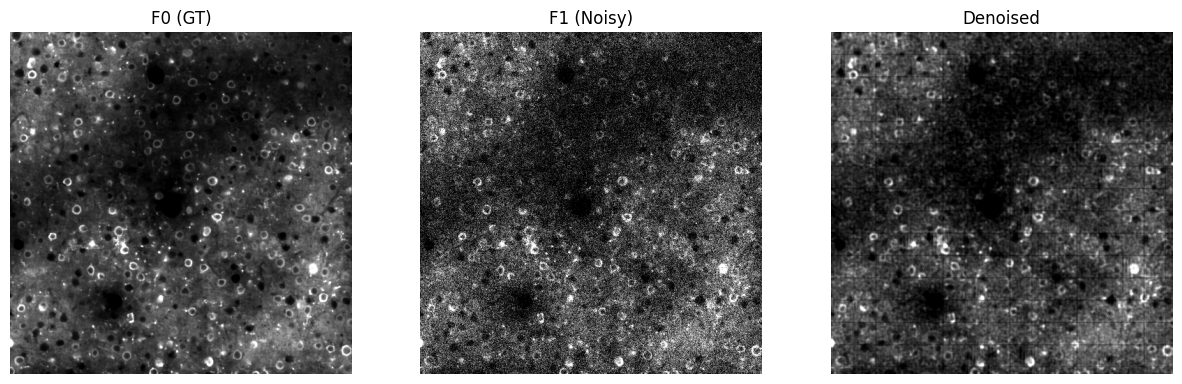

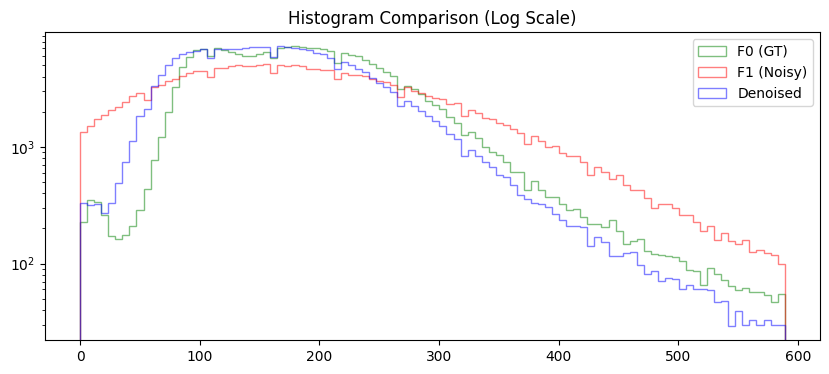

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def inspect_brightness(f0, f1, denoised):
    """
    輸入三個影像 (假設都是 Numpy Array)
    """
    imgs = [f0[0], f1[0], denoised[0]]
    names = ['F0 (GT)', 'F1 (Noisy)', 'Denoised']

    plt.figure(figsize=(15, 5))

    for i, (img, name) in enumerate(zip(imgs, names)):
        # 1. 印出統計數值 (最準確)
        print(f"[{name}] Min: {img.min():.4f}, Max: {img.max():.4f}, Mean: {img.mean():.4f}, Median: {np.median(img):.4f}")

        # 2. 畫圖 (用同樣的 vmin/vmax 比較才公平)
        # 我們統一用 F0 的標準來看
        vmin, vmax = np.percentile(f0, (1, 99.5))

        plt.subplot(1, 3, i+1)
        plt.title(name)
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        plt.axis('off')

    plt.show()

    # 3. 畫直方圖 (檢查背景有沒有偏移)
    plt.figure(figsize=(10, 4))
    plt.title("Histogram Comparison (Log Scale)")
    for img, name, color in zip(imgs, names, ['green', 'red', 'blue']):
        # flatten 拉平，bins 設多一點
        plt.hist(img.flatten(), bins=100, range=(np.percentile(f0, 0), np.percentile(f0, 99.5)),
                 alpha=0.5, label=name, color=color, log=True, histtype='step')
    plt.legend()
    plt.show()

inspect_brightness(ground_truth, valid_dataset.images[0], denoised_videos[0])